# Ground plane detection (single image)

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from depth_map import createMap

## Make disparity map

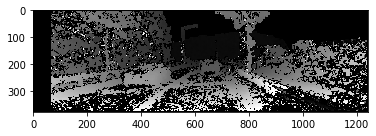

In [5]:
path_to_kitti = "KITTI/data_scene_flow/testing/"
disparity = createMap(path_to_kitti,'000183_11.png')
plt.imshow(disparity, 'gray');

In [6]:
# disparity of point on a car
disparity[250,475]

523

## Flatten disparity map, add u & v info
Need to revisit

In [7]:
u = np.tile(range(disparity.shape[1]), disparity.shape[0])
v = np.repeat(range(disparity.shape[0]), disparity.shape[1])
uv_disp = np.array([u,v,disparity.flatten()]).T

In [8]:
#u,v,disp
uv_disp

array([[   0,    0,  -16],
       [   1,    0,  -16],
       [   2,    0,  -16],
       ...,
       [1238,  375,  -16],
       [1239,  375,  -16],
       [1240,  375,  -16]])

## Remove -16 (no data) pixels

In [9]:
uv_disp_noblanks = uv_disp[uv_disp[:,2]!=-16]
uv_disp_noblanks

array([[  69,    4,  422],
       [  70,    4,  422],
       [  73,    4,  419],
       ...,
       [1233,  371,  217],
       [1234,  371,  219],
       [1235,  371,  219]])

In [10]:
from sklearn.linear_model import RANSACRegressor

In [11]:
u = uv_disp_noblanks[:,0].reshape(-1, 1)
v = uv_disp_noblanks[:,1].reshape(-1, 1)
d = uv_disp_noblanks[:,2]

## Plot

### U (horizontal scan)

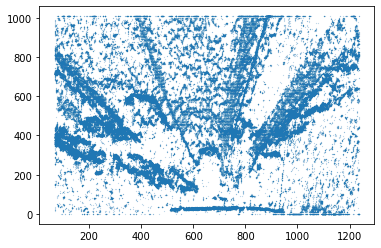

In [12]:
plt.scatter(x=u,y=d, s=0.01);

### V (vertical scan)

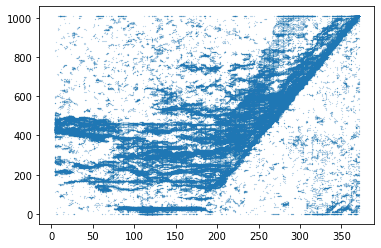

In [13]:
plt.scatter(x=v,y=d, s=0.01);

## Fit line to u, disp and v, disp

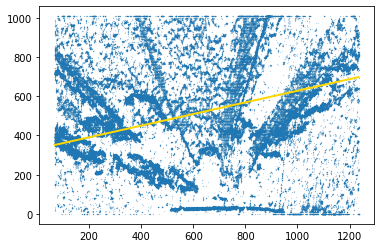

In [18]:
ransac_u = RANSACRegressor()
ransac_u.fit(u,d)
line_u = np.arange(u.min(), u.max())[:, np.newaxis]
line_du = ransac_u.predict(line_u)
plt.scatter(x=u,y=d,s=0.01)
plt.plot(line_u, line_du, color='gold',linewidth=2,label="Ransac regressor");


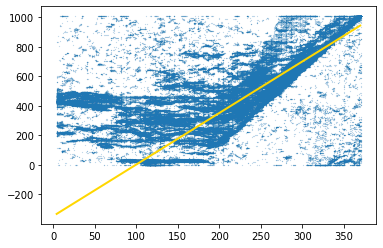

In [19]:
ransac_v = RANSACRegressor()
ransac_v.fit(v,d)
line_v = np.arange(v.min(), v.max())[:, np.newaxis]
line_dv = ransac_v.predict(line_v)
plt.scatter(x=v,y=d,s=0.01)
plt.plot(line_v, line_dv, color='gold',linewidth=2,label="Ransac regressor");

# Check each pixel to see if it fits

In [25]:
from PIL import Image
plt.imsave("temp.png", disparity)
img = Image.open("temp.png")

for i,disp in enumerate(d):
    x = line_u[u[i]-line_u[0]-1]-line_u[0]-1
    y = line_v[v[i]-line_v[0]-1]-line_v[0]-1
    if disp <= line_du[x] and disp <= line_dv[y]:
        img.putpixel((u[i][0],v[i][0]), (255,0,0))
    else:
        img.putpixel((u[i][0],v[i][0]), (0,255,0))
    
img.show();